<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/simple_edm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!pip install torch_geometric
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 8.9 MB/s eta 0:00:00


In [2]:
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hard Example

Data(x=[16, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H])[C@@]([H])([C@]24[H])[C@]13[H]', name='gdb_133885', idx=[1])


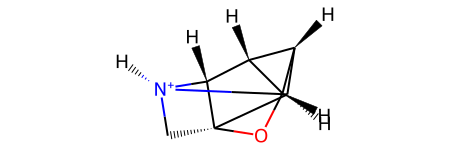

In [3]:
from torch_geometric.datasets import QM9
from rdkit import Chem

# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9
dataset = QM9(root='drive/MyDrive/Tutorial/data/QM9/')
ex_hard = dataset[-1]
ex_hard.pos = ex_hard.pos - ex_hard.pos.mean(dim=0)
print(ex_hard)
mol = Chem.MolFromSmiles(ex_hard.smiles)
mol

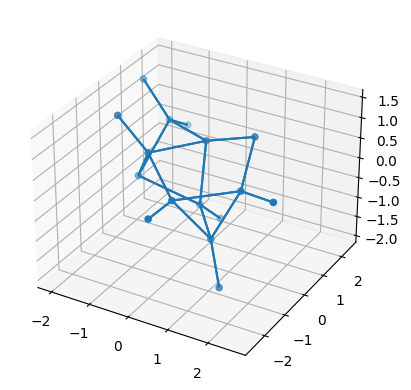

In [4]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt
import torch


def plot_molecule(example):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # draw nodes
  pos = example.pos
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

  # draw edges
  edge_index = example.edge_index
  starts = pos[edge_index[0].detach().numpy()]
  stops = pos[edge_index[1].detach().numpy()]
  lines = torch.hstack((starts, stops)).reshape((-1, 2, 3))
  ax.add_collection(Line3DCollection(lines))

plot_molecule(ex_hard)

## Medium Example

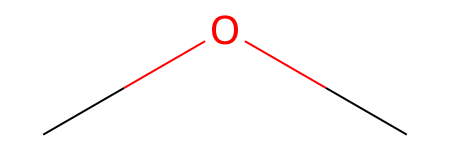

In [5]:
ex_medium = dataset[14]
ex_medium.pos = ex_medium.pos - ex_medium.pos.mean(dim=0)
mol = Chem.MolFromSmiles(ex_medium.smiles)
mol

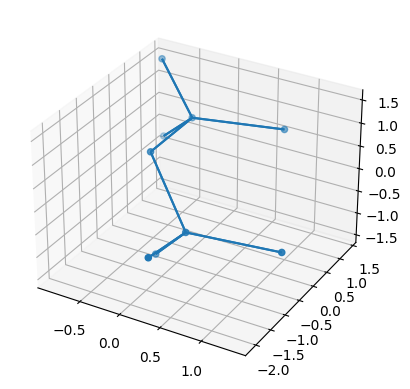

In [6]:
plot_molecule(ex_medium)

## Easy Example

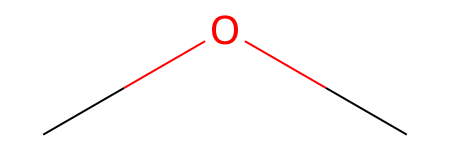

In [7]:
ex_easy = dataset[2]
ex_easy.pos = ex_easy.pos - ex_easy.pos.mean(dim=0)
mol = Chem.MolFromSmiles(ex_medium.smiles)
mol

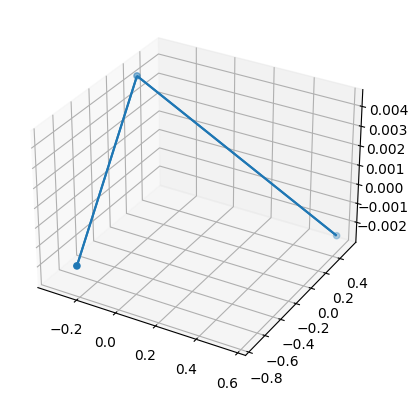

In [8]:
plot_molecule(ex_easy)

In [9]:
from scipy.spatial.transform import Rotation


def calc_rmsd(coords_a, coords_b):
    """
    From Martin Buttenschoen.
    Calculate RMSD assuming that the atom positions are ordered appropriately.
    """
    assert coords_a.shape == coords_b.shape
    coords_a, coords_b = transform(coords_a, coords_b)
    return (((coords_a - coords_b) ** 2).mean() * coords_a.shape[-1]).sqrt()


def transform(target, ref):
  # remove centroid
  target = target - torch.mean(target, dim=0, keepdim=True)
  ref = ref - torch.mean(ref, dim=0, keepdim=True)

  # rotate
  R, _ = Rotation.align_vectors(target, ref)
  target = torch.Tensor(R.apply(target))

  return target, ref

# Build EDM

## EGCL

In [10]:
class SimpleEGCL(nn.Module):
  def __init__(self, hidden=32):
    """Noise prediction layer used to parameterize the denoising model"""
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(1, hidden),
        nn.SiLU(),
        nn.Linear(hidden, 1, bias=False)
    )

    for layer in self.mlp:
      if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

  def forward(self, x, epsilon=1):
    """
    Input is a noisy latent representation of the coordinates. Since this is
    a GNN, we the latent representation has the same dimensions as the true
    point cloud. This particular layer is also equivariant (adapted from
    the E(n) layers).

    The output is the predicted noise that the model infers was added
    to some true latent representation of the coordinates.
    """
    diffs = x - x.unsqueeze(1)
    dists = torch.norm(diffs, dim=-1, keepdim=True)
    normalized = diffs / (dists + epsilon)
    batched_dists = dists.ravel().unsqueeze(-1)
    weights = self.mlp(batched_dists).reshape_as(dists)
    x_new = x + torch.sum(normalized * weights, dim=0)
    return x_new

## EGNN

In [11]:
class SimpleEGNN(nn.Module):
  def __init__(self, num_layers=4, hidden=32):
    """Denoising model"""
    super().__init__()
    self.egnn = nn.ModuleList([SimpleEGCL(hidden=hidden) for _ in range(num_layers)])

  def forward(self, z):
    for egcl in self.egnn:
      z = egcl(z)
    return z

In [12]:
from scipy.stats import ortho_group
import unittest

class TestSimpleEGNN(unittest.TestCase):

  def setUp(self):
    self.n = 10
    self.egnn = SimpleEGNN(num_layers=4)
    self.x = torch.rand((self.n, 3))
    self.y = self.egnn(self.x)

  def test_translation_equivariance(self):
    g = torch.rand(3)
    out1 = self.egnn(self.x + g)
    out2 = self.y + g
    self.assertTrue(torch.allclose(out1, out2, atol=1e-5))

  def test_rotation_equivariance(self):
    R = torch.tensor(ortho_group.rvs(3), dtype=torch.float32)
    out1 = self.egnn(self.x @ R)
    out2 = self.y @ R
    self.assertTrue(torch.allclose(out1, out2, atol=1e-5))

  def test_permutation_equivariance(self):
    indices = torch.randperm(self.n)
    out1 = self.egnn(self.x[indices])
    out2 = self.y[indices]
    self.assertTrue(torch.allclose(out1, out2, atol=1e-5))

unittest.main(argv=[''], defaultTest="TestSimpleEGNN", verbosity=2, exit=False)

test_permutation_equivariance (__main__.TestSimpleEGNN) ... ok
test_rotation_equivariance (__main__.TestSimpleEGNN) ... ok
test_translation_equivariance (__main__.TestSimpleEGNN) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.157s

OK


## Scheduler

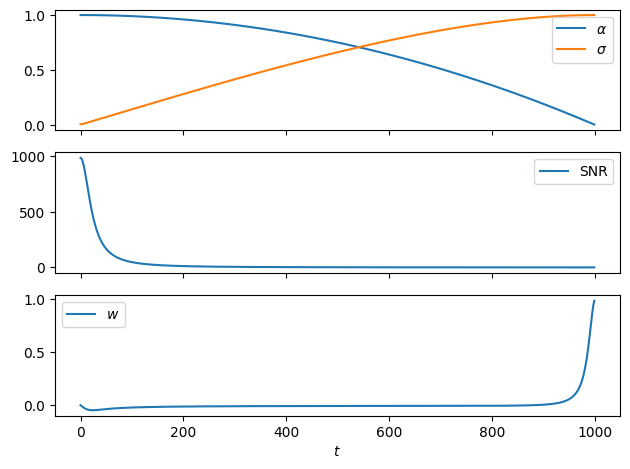

In [13]:
class Scheduler:
  def __init__(self, max_timesteps, eps=1e-3, s=1e-5, a_min=0.1):
    assert eps != 0
    self.max_timesteps = max_timesteps
    self._eps = eps
    self._s = s

    # for clipping
    self._a_min = a_min
    self._a_max = 1 - self._a_min

  def f(self, t):
    return 1 - (t / self.max_timesteps) ** 2

  def alpha(self, t, clip=False):
    """Controls how much signal is retained"""
    alpha = (1 - 2 * self._s) * self.f(t) + self._s
    if clip:
      alpha = np.clip(alpha, self._a_min, self._a_max)
    return alpha

  def sigma(self, t, clip=False):
    """Controls how much noise is added"""
    sigma = np.sqrt((1 - self.alpha(t) ** 2))
    if clip:
      sigma = np.clip(sigma, self._a_min, self._a_max)
    return sigma

  def snr(self, t):
    """Signal-to-noise ratio"""
    return self.alpha(t) ** 2 / (self.sigma(t) ** 2 + self._eps)

  def w(self, t):
    """
    True weighting for gradient steps.
    In practice, w(t) = 1 works better.
    """
    return 1 - self.snr(t - 1) / (self.snr(t) + self._eps)

  def calc_alphas(self, t, s, clip=False):
    """Helper for sample"""
    return {
        "t|s": self.alpha(t, clip) / self.alpha(s, clip)
    }

  def calc_sigmas(self, t, s, alpha, clip):
    """Helper for sample"""
    sigma_t = self.sigma(t, clip)
    sigma_s = self.sigma(s, clip)
    sigma = {
        "squared_t|s": sigma_t ** 2 - (alpha["t|s"] * sigma_s) ** 2,
        "t": sigma_t,
    }
    sigma["t->s"] = np.sqrt(sigma["squared_t|s"]) * sigma_s / sigma_t  # Bayes
    return sigma

  def plot(self):
    domain = np.arange(self.max_timesteps)
    fig, axs = plt.subplots(3, 1, sharex=True)
    axs[0].plot(domain, self.alpha(domain), label=r"$\alpha$")
    axs[0].plot(domain, self.sigma(domain), label=r"$\sigma$")
    axs[1].plot(domain, self.snr(domain), label=r"SNR")
    axs[2].plot(domain, self.w(domain), label=r"$w$")
    for ax in axs:
      ax.legend()
    axs[2].set_xlabel("$t$")
    plt.tight_layout()

scheduler = Scheduler(1000)
scheduler.plot()

## EDM

In [14]:
class SimpleEDM:
  def __init__(self, num_layers=4, hidden=32, max_timesteps=1000, lr=1e-3):
    self._model = SimpleEGNN(num_layers, hidden=hidden)
    self.mse = nn.MSELoss()
    self.optimizer = optim.Adam(self._model.parameters(), lr=lr)

    self.max_timesteps = max_timesteps
    self.s = Scheduler(max_timesteps)

    self.normal_dist = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))

  def predict_noise(self, z):
    pred_noise = self._model(z) - z
    centroid = torch.mean(pred_noise, dim=0)
    result = pred_noise - centroid
    return result

  def sample_noise(self, n):
    noise = self.normal_dist.sample(sample_shape=(n,))  # noise.shape = (n, 3)
    noise -= torch.mean(noise, dim=0)
    return noise

  def encoder(self, x, t, noise):
    """
    NOTE: forward step in diffusion process; uses 'reparam trick'
    to make expression deterministic WRT to x and thus diff'able
    so grads can prop. W/O this parameterization, z would be
    drawn from q(z_t|x). Since z would then be a stochastic sample,
    it wouldn't be differentiable and we wouldn't be able to use
    grad descent.
    """
    z = self.s.alpha(t) * x + self.s.sigma(t) * noise
    return z

  def decoder(self, z, t, noise):
    """
    See Kingma paper 'Variational Diffusion Models' equation (10)
    and Hoogeboom paper equation (16).
    """
    x = z / self.s.alpha(t) - self.s.sigma(t) * noise / self.s.alpha(t)
    return x

  def optimize(self, example, epochs=1000, true_weight=False):
    """
    In this toy example, our SimpleEDM's optimization tries to
    overfit on the positional information of a single example.
    """
    history = {k: [] for k in ("mse", "rmsd")}

    x = example.pos
    n = x.shape[0]

    lowest_loss = torch.inf
    best_weights = None

    for t in tqdm(torch.randint(self.max_timesteps + 1, (epochs,))):
      self.optimizer.zero_grad()
      noise = self.sample_noise(n)
      z = self.encoder(x, t, noise)  # noisy latent representation
      pred_noise = self.predict_noise(z)

      # MSE
      loss = self.mse(pred_noise, noise)
      if true_weight:
          loss *= self.s.w(t)
      loss.backward()
      self.optimizer.step()

      # update history and model
      history["mse"].append(loss.detach().numpy())
      if loss <= lowest_loss:
        best_weights = self._model.state_dict()
        lowest_loss = loss.item()

      # RMSD
      with torch.no_grad():
        pred_x = self.decoder(z, t, pred_noise)
        rmsd = calc_rmsd(pred_x, x)
        history["rmsd"].append(rmsd)

    self._model.load_state_dict(best_weights)
    return history

  def forward_diffuse(self, example):
    """Complete diffusion in single step"""
    x = example.pos
    n = x.shape[0]
    noise = self.sample_noise(n)
    return self.encoder(x, self.max_timesteps, noise)

  def reverse_diffuse(self):
    """Complete full reverse diffusion in single step"""
    with torch.no_grad():
      z = self.normal_dist.sample(sample_shape=(n,))
      pred_noise = self.predict_noise(z)
      x = self.decoder(z, self.max_timesteps, pred_noise)
      return x

  def sample(self, n: int, determinism=0, z_T=None, clip=False):
    history = {k: [] for k in ("x", "z")}
    with torch.no_grad():

      if z_T is None:
        z_t = self.normal_dist.sample(sample_shape=(n,))
      else:
        z_t = z_T

      for t in range(self.max_timesteps, 1, -1):
        # predict noise and x
        pred_noise = self.predict_noise(z_t)
        pred_x = self.decoder(z_t, t, pred_noise)
        history["x"].append(pred_x)
        history["z"].append(z_t)

        # apply reparam trick to get z_s
        s = t - 1
        alpha = self.s.calc_alphas(t, s, clip)
        sigma = self.s.calc_sigmas(t, s, alpha, clip)

        inv_alpha_ts = 1 / alpha["t|s"]
        if clip:
          inv_alpha_ts = np.clip(1 / alpha["t|s"], 0.1, 0.9)

        mean = (
            (z_t - sigma["squared_t|s"] / (sigma["t"]) * pred_noise) / alpha["t|s"]
        )

        if determinism == 0:
          z_s = mean + sigma["t->s"] * self.sample_noise(n)
        elif determinism == 1:
          z_s = mean + sigma["t->s"] * pred_noise
        else:
          z_s = mean


        z_t = z_s

      pred_noise = self.predict_noise(z_s)
      pred_x = self.decoder(z_s, 0, pred_noise)
      history["x"].append(pred_x)
      history["z"].append(z_s)

    return history

# Forward Difussion (Optimization)

In [15]:
working_example = ex_easy

  0%|          | 0/1000 [00:00<?, ?it/s]

loss=0.00015347525186371058
rmsd=0.006310195196419954


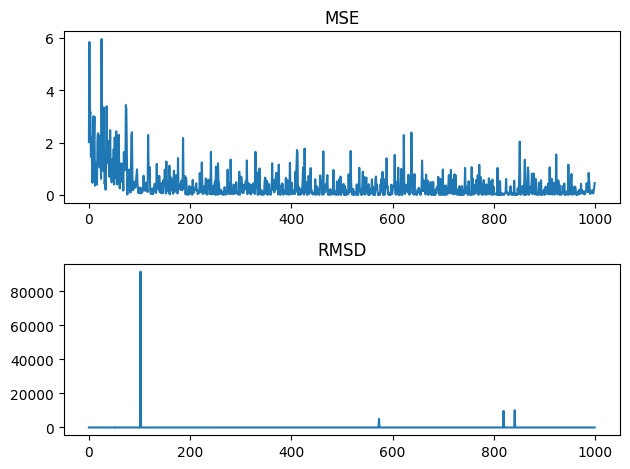

In [16]:
edm = SimpleEDM(num_layers=2, max_timesteps=200, hidden=10, lr=1e-3)
epochs = 1000
optimize_history = edm.optimize(working_example, epochs, true_weight=False)

loss = float(min(optimize_history["mse"]))
rmsd = float(min(optimize_history["rmsd"]))
print(f"{loss=}")
print(f"{rmsd=}")

fig, axs = plt.subplots(2, 1)
domain = range(epochs)
axs[0].plot(domain, optimize_history["mse"])
axs[0].set_title("MSE")
axs[1].plot(domain, optimize_history["rmsd"])
axs[1].set_title("RMSD")
fig.tight_layout()

# Reverse Process (Sampling)

## Bootstrap

In [23]:
x = working_example.pos
n = x.shape[0]
best_sample_history = None
best_rmsd = np.inf

In [24]:
print(f"{best_rmsd=}")
num_trials = 100
log_freq = 10
for i in tqdm(range(num_trials)):
  sample_history = edm.sample(n, determinism=0, clip=True)
  try:
    rmsd = float(calc_rmsd(sample_history["x"][-1], x))
    if rmsd <= best_rmsd:
      best_rmsd = rmsd
      print(f"{i=}, {best_rmsd=}")
      best_sample_history = sample_history
    if i % log_freq == 0:
      print(f"{i=}, {rmsd=}")
  finally:
    continue

best_rmsd=inf


  0%|          | 0/100 [00:00<?, ?it/s]

i=0, best_rmsd=0.2919452488422394
i=0, rmsd=0.2919452488422394
i=2, best_rmsd=0.17062149941921234
i=10, rmsd=1.116849422454834
i=20, rmsd=1.0589978694915771
i=30, rmsd=0.6548388004302979
i=36, best_rmsd=0.15839630365371704
i=40, rmsd=0.7388961315155029
i=50, rmsd=1.1385397911071777
i=60, rmsd=0.8229383230209351
i=70, rmsd=0.8540595173835754
i=80, rmsd=1.257948875427246
i=90, rmsd=0.2604910433292389


## Anaylsis

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

x_max_rmsd=28515.548828125
x_min_rmsd=0.06605801731348038
x_last_rmsd=0.15839630365371704

z_max_rmsd=2.1192526817321777
z_min_rmsd=0.07188490778207779
z_last_rmsd=0.15979786217212677


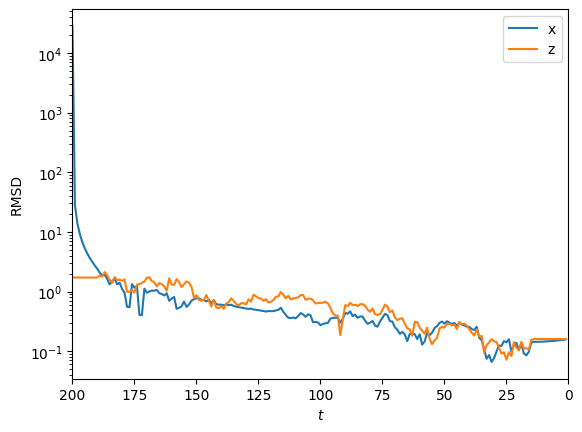

In [25]:
x_rmsd_history = [calc_rmsd(pred_x, x) for pred_x in tqdm(best_sample_history["x"])]
z_rmsd_history = [calc_rmsd(pred_x, x) for pred_x in tqdm(best_sample_history["z"])]

x_max_rmsd = float(max(x_rmsd_history).numpy())
x_min_rmsd = float(min(x_rmsd_history).numpy())
x_last_rmsd = float(x_rmsd_history[-1].numpy())
z_max_rmsd = float(max(z_rmsd_history).numpy())
z_min_rmsd = float(min(z_rmsd_history).numpy())
z_last_rmsd = float(z_rmsd_history[-1].numpy())
print(f"{x_max_rmsd=}")
print(f"{x_min_rmsd=}")
print(f"{x_last_rmsd=}")
print()
print(f"{z_max_rmsd=}")
print(f"{z_min_rmsd=}")
print(f"{z_last_rmsd=}")


plt.xlim(edm.max_timesteps, 0)
plt.plot(range(edm.max_timesteps, 0, -1), x_rmsd_history, c="C0", label="x")
plt.plot(range(edm.max_timesteps, 0, -1), z_rmsd_history, c="C1", label="z")
plt.ylabel("RMSD")
plt.yscale('log')
plt.xlabel("$t$")
plt.legend()
# plt.savefig("drive/MyDrive/Tutorial/water_rmsd.png")

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'RMSD: 0.15840'}>)

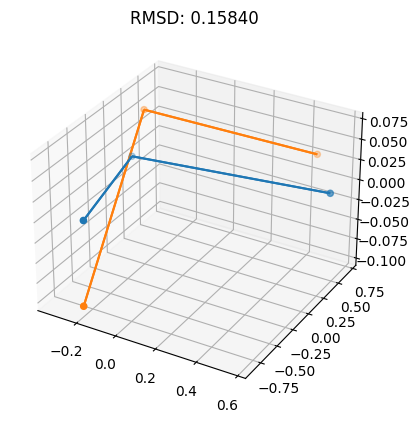

In [26]:
def plot_molecules(example, pred_pos, show=False):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  pos = example.pos
  rmsd = "{:.5f}".format(float(calc_rmsd(pred_pos, pos).numpy()))
  plt.title(f"RMSD: {rmsd}")
  pred_pos, pos = transform(pred_pos, pos)
  pred_pos = pred_pos.numpy()
  pos = pos.numpy()

  # draw nodes
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c="C0")
  ax.scatter(pred_pos[:, 0], pred_pos[:, 1], pred_pos[:, 2], c="C1")

  # reorder coords and edges
  sorted_indices = np.argsort(pos[:, 0])
  pos = pos[sorted_indices]
  pred_pos = pred_pos[np.argsort(pred_pos[:, 0])]
  replacements = {j: i for i, j in enumerate(sorted_indices)}
  edge_index = np.vectorize(replacements.get)(example.edge_index)

  # draw edges
  for i, x in enumerate((pos, pred_pos)):
    starts = x[edge_index[0]]
    stops = x[edge_index[1]]
    lines = np.hstack((starts, stops)).reshape((-1, 2, 3))
    ax.add_collection(Line3DCollection(lines, color=f"C{i}"))

  return fig, ax

plot_molecules(working_example, best_sample_history["x"][-1], show=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'RMSD: 17652.76562'}>)

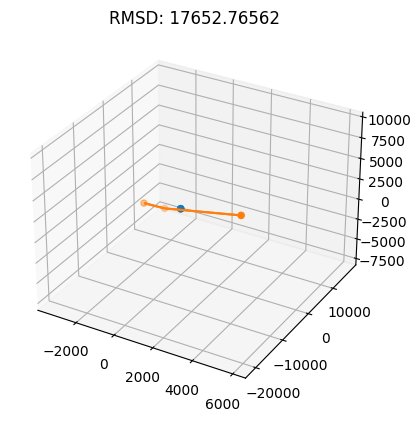

In [27]:
# The naive reverse diffusion takes no steps and should perform much worse!
plot_molecules(working_example, edm.reverse_diffuse())

In [28]:
from PIL import Image
from IPython.display import HTML
import io

def fig2img(fig):
    """
    Adapted from: https://stackoverflow.com/a/61754995/15001799
    Convert a Matplotlib figure to a PIL Image and return it
    """
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def animate_reverse_diffusion(example, history, save_path="drive/MyDrive/Tutorial/reverse_diffusion.gif"):
  frames = []
  for pred_pos in tqdm(history):
    fig, ax = plot_molecules(example, pred_pos)

    # # Hide grid lines
    # ax.grid(False)

    # # Hide axes ticks
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])

    frames.append(fig2img(fig))
    plt.close()

  frames[0].save(save_path, save_all=True, append_images=frames[1:], duration=120, optimize=False, quality=20)

# animate_reverse_diffusion(working_example, best_sample_history["x"])